In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd "/content/drive/MyDrive/Colab_Notebooks/Unet/"

Mounted at /content/drive/
/content/drive/MyDrive/Colab_Notebooks/Unet


In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

import pickle
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 高解像度モデルの作成
画像生成分野にはGANが有名であるが、エンコーダ・デコーダモデルも有名。<br>
GANの訓練ではディスクリミネーターとジェネレータのバランスが難しいこともあり、<br>
実装のしやすいエンコーダ・デコーダモデルを用いて高解像度化を図ってみる。<br>

## 手法について
比較的高解像度な画像を教師データ、教師データをダウンサンプルしたものを訓練データとし、<br>
教師画像に近づけるよう高解像度画像を生成させる。<br>

エンコーダ・デコーダによる潜在的な特徴量の抽出に加え、<br>
圧縮時の情報をデコードに受け渡せるスキップ構造を取り入れる。

## 訓練データの準備

データセットはSTL_10を使用<br>
画像サイズは96x96
画像枚数は5000枚

In [3]:
x_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((48, 48))]) # 訓練データはあらかじめダウンサンプリング
y_transform = transforms.Compose(
    [transforms.ToTensor()]
)

x_train = datasets.STL10(root='/content/drive/MyDrive/Colab_Notebooks/Unet/data_sets/', 
                           split = 'train',
                           download=True,
                           transform=x_transform)
print(x_train)

y_train = datasets.STL10(root='/content/drive/MyDrive/Colab_Notebooks/Unet/data_sets/', 
                           split = 'train',
                           download=True,
                           transform=y_transform)
print(y_train)

x_test = datasets.STL10(root='/content/drive/MyDrive/Colab_Notebooks/Unet/data_sets/', 
                           split = 'test',
                           download=True,
                           transform=x_transform)
print(x_test)

y_test = datasets.STL10(root='/content/drive/MyDrive/Colab_Notebooks/Unet/data_sets/', 
                           split = 'test',
                           download=True,
                           transform=y_transform)
print(y_test)

Files already downloaded and verified
Dataset STL10
    Number of datapoints: 5000
    Root location: /content/drive/MyDrive/Colab_Notebooks/Unet/data_sets/
    Split: train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(48, 48), interpolation=bilinear, max_size=None, antialias=None)
           )
Files already downloaded and verified
Dataset STL10
    Number of datapoints: 5000
    Root location: /content/drive/MyDrive/Colab_Notebooks/Unet/data_sets/
    Split: train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Files already downloaded and verified
Dataset STL10
    Number of datapoints: 8000
    Root location: /content/drive/MyDrive/Colab_Notebooks/Unet/data_sets/
    Split: test
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(48, 48), interpolation=bilinear, max_size=None, antialias=None)
           )
Files already downloaded and verified
Dataset STL10


In [12]:
# 画像を表示する関数
def torch_img(torch_datasets, fig_size, matrix):
    """
    引数
    torch_datasets : torchvision.datasets_ torchvisionのデータセットフォーマット
    fig_size : tuple(height, wight)_ フィールドサイズ
    matrix : tuple（row , column）_ 縦横枚数
    """
    f_h, f_w = fig_size
    row, column = matrix

    fig = plt.figure(figsize=(f_w, f_h))
    img_num = row * column
    for id, trg in enumerate(torch_datasets):
        trg = trg[0].cpu().detach().numpy()
        img = np.transpose(trg, (1, 2, 0))
        a = fig.add_subplot(row, column, id+1)
        a.axis('off')
        a.imshow(img)
        if id == (img_num-1):break

In [13]:
# 訓練したモデルを呼び出してtorch_imgに使用できるようにする関数
def models_im(path, model, nums, data=x_test):
    """
    引数
    path : str_ モデルの保存先
    model : Module_ 使用するモデルクラス
    nums : int_ 生成画像枚数
    data : モデルへの入力データ（torchvision.datasets_ torchvisionのデータセットフォーマット）
    """
    model = model
    model.load_state_dict(torch.load(path, torch.device("cpu")))
    model.eval()
    model_im = None
    for index in range(10):
        target = torch.unsqueeze(x_test[index][0], 0)
        target= model(target)
        if target.min() < 0:
            target += -torch.min(target) # モデルが負の値を生成した場合の全て正の値になるようシフトする
        target = (target/torch.max(target)) # 画像出力を0-1に正規化(floatのため0-255ではなく0-1)
        if model_im == None:
            model_im = target
        else:
            model_im = torch.concat((model_im, target))
    model_im = torch.unsqueeze(model_im, 1)

    return model_im

## アーキテクチャ
エンコードは (3×48×48) を (512×3×3) に圧縮。<br>
フィルターは3、パディングは1、ストライドは2。<br>
デコードでは (512×3×3) を (3×96×96) へ拡大。<br>
デーコード時のフィルターは4。<br>
デコード時とサイズが同じになるように圧縮と拡張を行い、<br>
スキップ構造でエンコード時の情報をデコード層に和を取る形で受け渡す.


In [7]:
class Unet(nn.Module):


    def __init__(self, hidden_dim):
        """
        引数
        hidden_dim : scaler_ 一層目の出力後のチャネルサイズ(64)
        """
        super(Unet, self).__init__()
        stride = 2
        padding = 1
        # encode_layer
        self.en_layer1 = nn.Sequential(
            nn.Conv2d(3, hidden_dim, 3, stride=stride, padding=padding), # 3 -> 64, (48x48) -> (24x24)
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU()
        )
        self.en_layer2 = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim*2, 3, stride=stride, padding=padding),  # 64 -> 128, (24x24) -> (12x12)
            nn.BatchNorm2d(hidden_dim*2),
            nn.ReLU()
        )
        self.en_layer3 = nn.Sequential(
            nn.Conv2d(hidden_dim*2, hidden_dim*4, 3, stride=stride, padding=padding), # 128 -> 256, (12x12) -> (6x6)
            nn.BatchNorm2d(hidden_dim*4),
            nn.ReLU()
        )
        self.en_layer4 = nn.Sequential(
            nn.Conv2d(hidden_dim*4, hidden_dim*8, 3, stride=stride, padding=padding), # 256 -> 512, (6x6) -> (3x3)
            nn.BatchNorm2d(hidden_dim*8),
            nn.ReLU()
        )        

        # cat_decode_layer
        self.cat_layer1 = nn.Sequential(
            nn.Conv2d(hidden_dim*8*2, hidden_dim*8, 3, stride=1, padding=padding), # 512+512 -> 512, (3x3) -> (3x3)
            nn.BatchNorm2d(hidden_dim*8),
            nn.ReLU()
        )
        self.dec_layer1 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim*8, hidden_dim*4, 4, stride=stride, padding=padding), # 512 -> 256, (3x3) -> (6x6)
            nn.BatchNorm2d(hidden_dim*4),
            nn.ReLU()
        )
        self.cat_layer2 = nn.Sequential(
            nn.Conv2d(hidden_dim*4*2, hidden_dim*4, 3, stride=1, padding=padding), # 256+256 -> 256, (6x6) -> (6x6)
            nn.BatchNorm2d(hidden_dim*4),
            nn.ReLU()
        )
        self.dec_layer2 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim*4, hidden_dim*2, 4, stride=stride, padding=padding),  # 256 -> 128, (6x6) -> (12x12)
            nn.BatchNorm2d(hidden_dim*2),
            nn.ReLU()
        )
        self.cat_layer3 = nn.Sequential(
            nn.Conv2d(hidden_dim*2*2, hidden_dim*2, 3, stride=1, padding=padding), # 128+128 -> 128, (12x12) -> (12x12)
            nn.BatchNorm2d(hidden_dim*2),
            nn.ReLU()
        )
        self.dec_layer3 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim*2, hidden_dim, 4, stride=stride, padding=padding), # 128 -> 64, (12x12) -> (24x24)
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU()
        )

        self.cat_layer4 = nn.Sequential(
            nn.Conv2d(hidden_dim*2, hidden_dim, 3, stride=1, padding=padding), # 64+64 -> 64, (24x24) -> (24x24)
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU()
        )
        self.dec_layer4 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim, int(hidden_dim/2), 4, stride=stride, padding=padding), # 64 -> 32, (24x24) -> (48x48)
            nn.BatchNorm2d(int(hidden_dim/2)),
            nn.ReLU()
        )
        self.cat_layer5 = nn.Sequential(
            nn.Conv2d(int(hidden_dim/2)*2, int(hidden_dim/2), 3, stride=1, padding=padding), # 32+32 -> 32, (48x48) -> (48x48)
            nn.BatchNorm2d(int(hidden_dim/2)),
            nn.ReLU()
        )
        self.dec_layer5 = nn.Sequential(
            nn.ConvTranspose2d(int(hidden_dim/2), 3, 4, stride=stride, padding=padding), # 32 -> 3, (48x48) -> (96x96)
            nn.BatchNorm2d(3),
        )

        self.encode_sequence = [self.en_layer1, self.en_layer2, self.en_layer3, self.en_layer4]
        self.decode_sequence = [self.dec_layer1, self.dec_layer2, self.dec_layer3, self.dec_layer4, self.dec_layer5]
        self.cat_sequnce = [self.cat_layer1, self.cat_layer2, self.cat_layer3, self.cat_layer4, self.cat_layer5]


    def forward(self, x):
        """
        引数
        x : Tensor([N, C, H, W])_ 入力データ[バッチサイズ, チャネル数, 高さ, 幅]
        """
        encoded_layer = []
        for en in self.encode_sequence:
            x = en(x)
            encoded_layer.append(x)

        for cat, dec in zip(self.cat_sequnce, self.decode_sequence):
            if encoded_layer != []: # encoded_layerに情報があればdequeで取り出す
                x = torch.concat((x, encoded_layer[len(encoded_layer) - 1]), 1) # 各エンコーダの情報を対応するデコーダへ連結して畳み込み
                del(encoded_layer[len(encoded_layer) - 1])
                x = cat(x)
            x = dec(x)

        return x

## モデルの学習
損失関数はMSEを使用する.<br>
モデルの成長度合いを目視的に確認するため5エポックごとにモデルを保存する。<br>
今回は20エポックまで。

In [11]:
num_epochs = 20
batch_size = 100
learning_rate = 1e-3
saving = True

# upsamperで設定した枚数をバッチサイズで分割
x_trains = DataLoader(x_train, batch_size=batch_size)
y_trains = DataLoader(y_train, batch_size=batch_size)

x_tests = DataLoader(x_test, batch_size=batch_size)
y_tests = DataLoader(y_test, batch_size=batch_size)


loss_list = []
loss_test = []
# モデルの定義
model = Unet(hidden_dim=64).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 訓練
for epoch in range(num_epochs):
    for data in zip(x_trains, y_trains, x_tests, y_tests):
        model.train()
        target = torch.Tensor(data[0][0]).to(device)
        out_put = model(target)
        loss = criterion(out_put, data[1][0].to(device))

        loss_list.append(float(loss))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        model.eval()
        target = torch.Tensor(data[2][0]).to(device)
        out_put = model(target)

        loss = criterion(out_put, data[3][0].to(device))
        loss_test.append(float(loss))
    
    print("epoch : ", str(epoch + 1), "  loss : ", str(loss))
    # モデルの保存(5epochごと)
    if saving == True:
        model_path = 'models/u_net/(epoch:{}, batch_size:{}).pth'.format(str(epoch + 1), str(batch_size))
        torch.save(model.state_dict(), model_path)
        if (epoch+1)%5==0:
            model_path = 'models/u_net/(epoch:{}, batch_size:{}).pth'.format(str(epoch + 1), str(batch_size))
            torch.save(model.state_dict(), model_path)

# lossリストの保存
if saving == True:
    with open('loss_list/train_loss(u_net, epoch:{}, batch_size:{}).pickle'.format(str(num_epochs), str(batch_size)), mode='wb') as f:
        pickle.dump(loss_list, f)
    with open('loss_list/train_loss(u_net(test), epoch:{}, batch_size:{}).pickle'.format(str(num_epochs), str(batch_size)), mode='wb') as f:
        pickle.dump(loss_test, f)

epoch :  1   loss :  tensor(0.4661, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch :  2   loss :  tensor(0.4822, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch :  3   loss :  tensor(0.4202, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch :  4   loss :  tensor(0.3564, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch :  5   loss :  tensor(0.2991, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch :  6   loss :  tensor(0.2492, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch :  7   loss :  tensor(0.2073, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch :  8   loss :  tensor(0.1721, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch :  9   loss :  tensor(0.1423, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch :  10   loss :  tensor(0.1173, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch :  11   loss :  tensor(0.0962, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch :  12   loss :  tensor(0.0785, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch :  13   loss :  ten

テストデータを使用したlossもAEよりU_netの方が低いようだ

## 画像の生成
U_Net, AEで生成した画像を表示する.
<br>左がU_Netで生成されたデータ, 中央が正解データ, 右がAEで生成されたデータ.
<br>上から順にbatch_sizeが100, 500, 1000のパラメータで作成されたモデル.

In [14]:
unets = [None]*4
for i in range(5, 21, 5):
    path = "models/u_net/(epoch:{}, batch_size:100).pth".format(i)
    model = Unet(64)
    model_im = models_im(path, model, 10)
    unets[int(i/5-1)] = model_im

fig_size = (6,60)
matrix = (1,10)
for trg in unets:
    torch_img(trg, fig_size, matrix)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
path = "models/skip_ae/" + "(epoch:20, batch_size:100).pth"
model = Model(64)
nums = 10
img = models_im(path, model, nums)
img.shape

torch.Size([10, 1, 3, 96, 96])

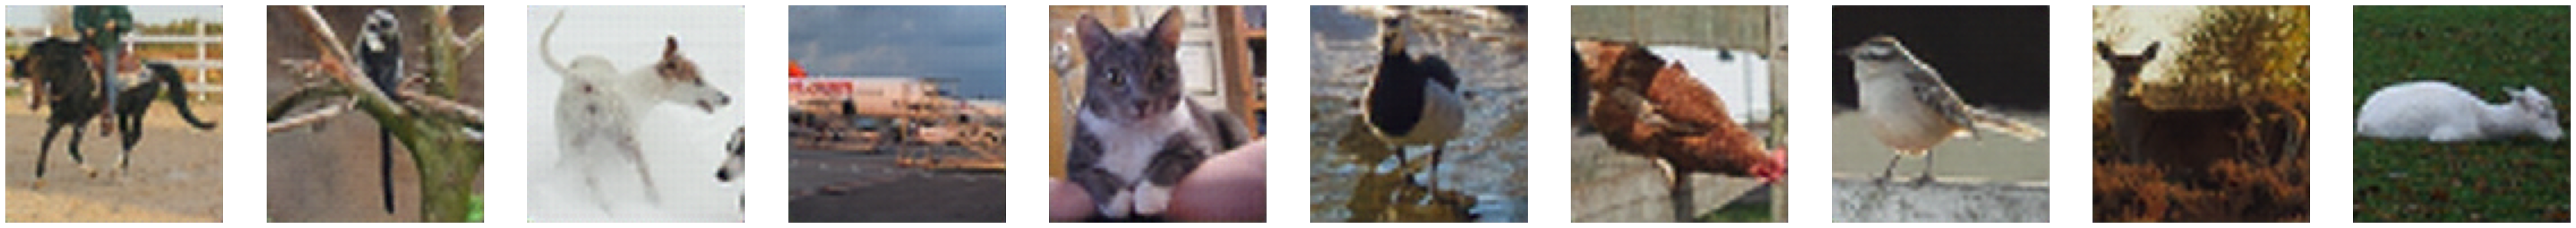

In [ ]:
fig_size = (6,60)
matrix = (1,10)
torch_img(img, fig_size, matrix)

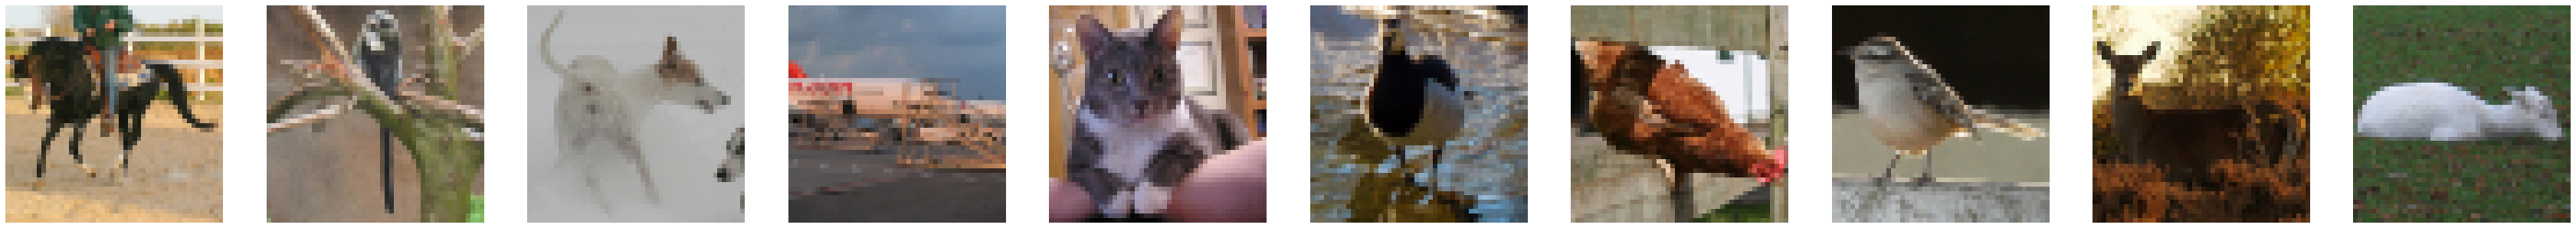

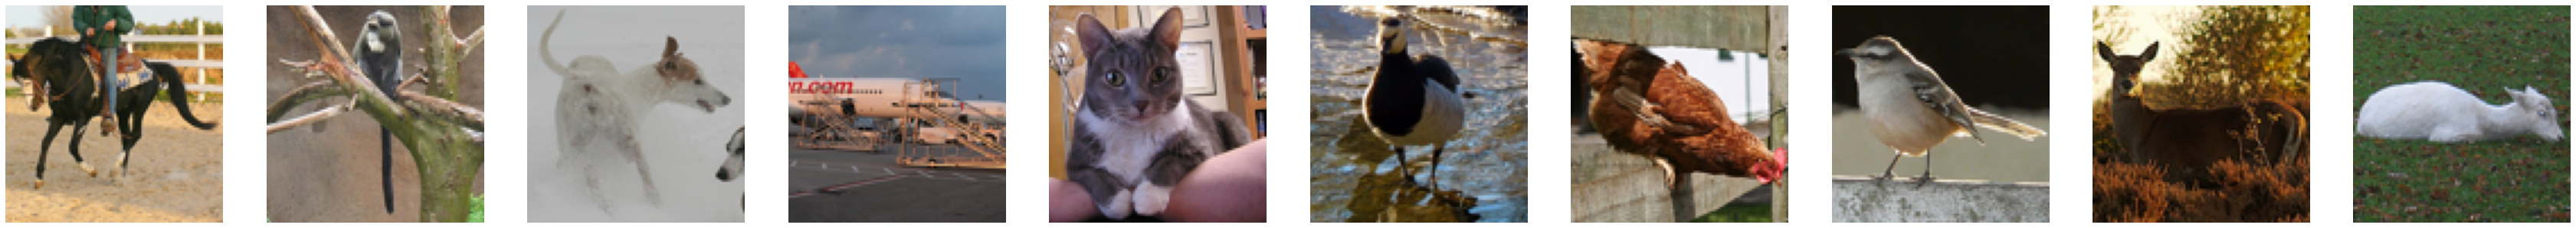

In [ ]:
torch_img(x_test, fig_size, matrix)
torch_img(y_test, fig_size, matrix)

## 損失について
batch_size = 1000 における訓練時の損失
<br>TrueがU_Net, FalseがAE.
<br>U_Netの方がlossが小さくエンコード時の情報が貢献していることが確認できる.

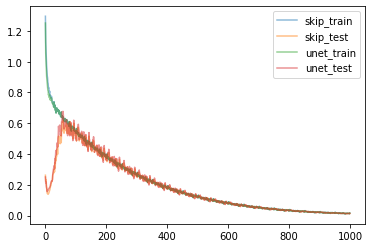

In [ ]:
with open('loss_list/train_loss(skip_ae, epoch:20, batch_size:100).pickle', mode='rb') as f:
    train_loss = pickle.load(f)
with open('loss_list/train_loss(skip_ae(test), epoch:20, batch_size:100).pickle', mode='rb') as f:
    test_loss = pickle.load(f)
with open('loss_list/train_loss(u_net, epoch:20, batch_size:100).pickle', mode='rb') as f:
    train_loss2 = pickle.load(f)
with open('loss_list/train_loss(u_net(test), epoch:20, batch_size:100).pickle', mode='rb') as f:
    test_loss2 = pickle.load(f)

plt.plot(train_loss, label="skip_train", alpha=0.5)
plt.plot(test_loss, label="skip_test", alpha=0.5)
plt.plot(train_loss2, label="unet_train", alpha=0.5)
plt.plot(test_loss2, label="unet_test", alpha=0.5)
plt.ylim()
plt.xlim()
plt.legend()

## 考察
AEで生成された画像は教師データに対して似つかないものとなった. <br>対してU_Netではしっかりと教師データの特徴を捉えた画像が生成されている. <br>batch_sizeについては今回のデータ数であれば小さいほど教師データの特徴をしっかり取られているようである. 
<br><br>
ただU_Netのモデルでは画像の特徴を捉えているがノイズがひどい. <br>教師データにより近づけるためには, 意図的に学習データにノイズを混ぜてDenoisingさせる必要がある.
<br><br>
高解像度化のモデルを作成するには, やはり高解像度画像を教師データにする必要があると感じる.<br>次回は訓練データに高解像度画像をダウンサンプルし, 一様にノイズを混ぜたものを使用してモデルを作成することで改善を図りたい.
